Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is to make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib
import matplotlib.pyplot as plt

In [3]:
pickle_file = '/Users/desiredewaele/git/datasets/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


These are some helper functions.

In [5]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

In [72]:
def viewer(accBatch, accValid, lossBatch, lossValid):
    fig = plt.figure(figsize=(15, 8)); ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)

    ax1.plot(np.arange(0, len(accBatch), 1), accBatch,".-", color='#2A6EA6', label="Training: {0:.2f}%".format(accBatch[-1]))
    ax1.plot(np.arange(0, len(accValid), 1), accValid,".-", color='#FFA933', label="Validation: {0:.2f}%".format(accValid[-1]))
    ax1.grid(True); ax1.legend(loc="lower right"); ax1.set_title("Accuracy per epoch")

    ax2.plot(np.arange(0, len(lossBatch), 1), lossBatch,".-", color='#2A6EA6', label="Training: {0:.2f}".format(lossBatch[-1]))
    #ax2.plot(np.arange(0, len(lossValid), 1), lossValid,".-", color='#FFA933', label="Validation: {0:.2f}".format(lossValid[-1]))
    ax2.grid(True); ax2.legend(loc="upper right"); ax2.set_title("Cost per epoch")
    plt.show()

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [81]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_valid_labels = tf.constant(valid_labels)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    w1 = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    w2 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    w3 = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    w4 = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    
    b1 = tf.Variable(tf.zeros([depth]))
    b2 = tf.Variable(tf.constant(1.0, shape=[depth]))
    b3 = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    b4 = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    # Model.
    def model(data):
        x = tf.nn.conv2d(data, w1, [1, 2, 2, 1], padding='SAME')
        x = tf.nn.relu(x + b1)
        x = tf.nn.conv2d(x, w2, [1, 2, 2, 1], padding='SAME')
        x = tf.nn.relu(x + b2)
        shape = x.get_shape().as_list()
        x = tf.reshape(x, [shape[0], shape[1] * shape[2] * shape[3]])
        x = tf.nn.relu(tf.matmul(x, w3) + b3)
        return tf.matmul(x, w4) + b4
  
    # Training computation.
    tLogits = model(tf_train_dataset)
    vLogits = model(tf_valid_dataset)
    lossTrain = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=tLogits, labels=tf_train_labels))
    lossValid = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=vLogits, labels=tf_valid_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(lossTrain)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(tLogits)
    valid_prediction = tf.nn.softmax(vLogits)
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [82]:
num_steps = 1001
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    lossBatch, lossValid, accBatch, accValid = [], [], [], []
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, lt, lv, predictions = session.run([optimizer, lossTrain, lossValid, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            lossBatch.append(lt)
            accBatch.append(accuracy(predictions, batch_labels))
            accValid.append(accuracy(valid_prediction.eval(), valid_labels))
            print('.', end=""),
    print('\nTest accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

[]
.[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
.[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
.[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
.[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
.[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
.[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
.[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


KeyboardInterrupt: 

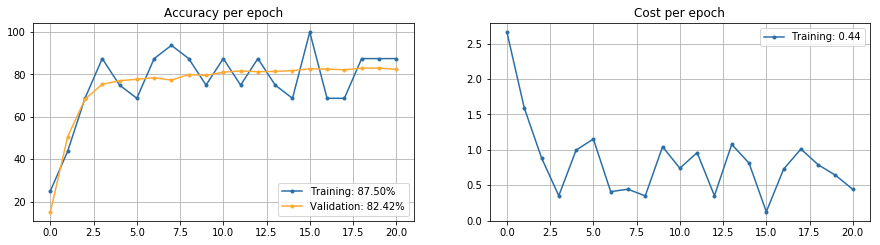

In [75]:
viewer(accBatch, accValid, lossBatch, lossValid)

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [10]:
batch_size = 32
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    def feedForward(data):
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        bias1 = tf.nn.relu(conv1 + layer1_biases)
        pool1 = tf.nn.max_pool(bias1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding='SAME')
        bias2 = tf.nn.relu(conv2 + layer2_biases)
        pool2 = tf.nn.max_pool(bias2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        shape = pool2.get_shape().as_list()
        reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = feedForward(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(feedForward(tf_valid_dataset))
    test_prediction = tf.nn.softmax(feedForward(tf_test_dataset))

In [11]:
num_steps = 1001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    lossList, accBatch, accValid = [], [], []
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            lossList.append(l)
            accBatch.append(accuracy(predictions, batch_labels))
            accValid.append(accuracy(valid_prediction.eval(), valid_labels))
            print('.', end=""),
    print('\nTest accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

.....................
Test accuracy: 91.3%


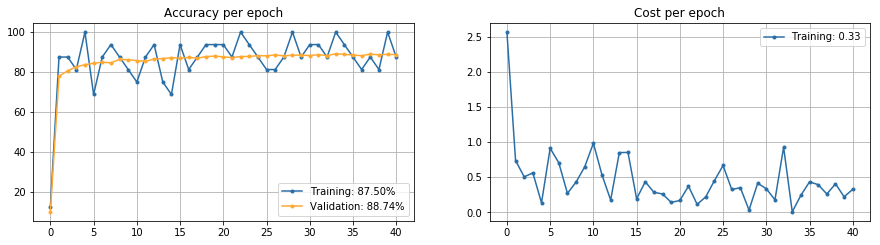

In [21]:
viewer(accBatch, accValid, lossList)

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

In [13]:
print(train_dataset.shape)

(200000, 28, 28, 1)


In [14]:
train_labels.shape

(200000, 10)

In [16]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    w1 = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    w2 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    size3 = ((image_size - patch_size + 1) // 2 - patch_size + 1) // 2
    w3 = tf.Variable(tf.truncated_normal([size3 * size3 * depth, num_hidden], stddev=0.1))
    w4 = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    
    b1 = tf.Variable(tf.zeros([depth]))
    b2 = tf.Variable(tf.constant(1.0, shape=[depth]))
    b3 = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    b4 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data):
        x = tf.nn.conv2d(data, w1, [1, 1, 1, 1], padding='VALID')
        x = tf.nn.relu(x + b1)
        x = tf.nn.avg_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
        x = tf.nn.conv2d(x, w2, [1, 1, 1, 1], padding='VALID')
        x = tf.nn.relu(x + b2)
        x = tf.nn.avg_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
        shape = x.get_shape().as_list()
        x = tf.reshape(x, [shape[0], shape[1] * shape[2] * shape[3]])
        x = tf.nn.relu(tf.matmul(x, w3) + b3)
        return tf.matmul(x, w4) + b4
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [17]:
num_steps = 20001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    lossList, accBatch, accValid = [], [], []
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed)
        if (step % 500 == 0):
            lossList.append(l)
            accBatch.append(accuracy(predictions, batch_labels))
            accValid.append(accuracy(valid_prediction.eval(), valid_labels))
            print('.', end=""),
    print('\nTest accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

.........................................
Test accuracy: 94.9%


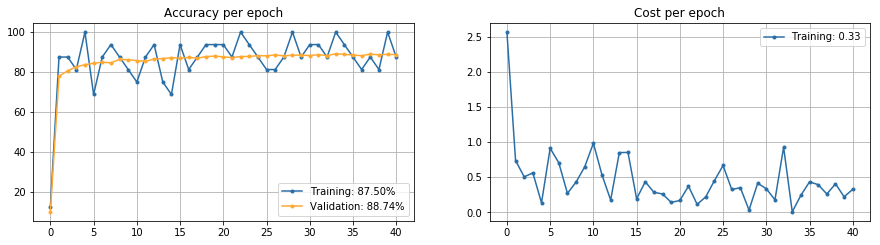

In [20]:
viewer(accBatch, accValid, lossList)